<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Project_3_7_Istanbul_Traffic_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Istanbul Traffic Object Detection

# Prepare the Environment

In [ ]:
import random
import shutil
import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path

import torch
import yaml
from PIL import Image
from tqdm.notebook import tqdm
from ultralytics import YOLO

Since GPUs are available on your machine, make sure you handle placing the tensors to the proper device.

**Task 3.7.1:** Check the availability of GPUs on this machine and determine the correct device name. Store the device name in the variable `device`.

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device.")

# output
Using cuda device.

### Check the data

The bounding box data is provided using the XML file format. Unfortunately, both the images and XML files are in the same directory, `istanbul_traffic/train`. We'll need rearrange the files and directories in the form we'll need later. Let's take a peek at the current directory hierarchy.

In [ ]:
!tree istanbul_traffic --filelimit=10

#output
istanbul_traffic
├── test [279 entries exceeds filelimit, not opening dir]
└── train [11610 entries exceeds filelimit, not opening dir]

2 directories, 0 files

**Task 3.7.2:** Create a variable for the train directory using `pathlib` syntax, `istanbul_traffic/train`.

In [ ]:
istanbul_dir = Path("istanbul_traffic", "train")

print("Training data directory:", istanbul_dir)

#output
Training data directory: istanbul_traffic/train


There should be one XML file for each JPG image. The corresponding XML and JPG share the same filename except for the file extension. E.g., `0ab6f274892b9b370e6441886b2d7b9d.jpg` and `0ab6f274892b9b370e6441886b2d7b9d.xml` belong together. We should verify that each training image has a corresponding XML file.

**Task 3.7.3:** Create a variable that counts how many files have the same base name.

In [ ]:
file_extension_counts = Counter(Path(file).stem for file in istanbul_dir.iterdir())

istanbul_dir.iterdir() goes through all files/folders in the directory.

Path(file).stem gets just the base name of each file — without the extension.

Counter(...) counts how many times each base name appears.

In [ ]:
print(
    f"Number of files with 0ab6f274892b9b370e6441886b2d7b9d basename: {file_extension_counts['0ab6f274892b9b370e6441886b2d7b9d']}"
)

#output
Number of files with 0ab6f274892b9b370e6441886b2d7b9d basename: 2


**Task 3.7.4:** Check that all of the values in `file_extension_counts` are 2.  An easy way to do this is to pass all of the values into a `set` object. Submit all the unique counts to the grader.

In [ ]:
unique_counts = set(file_extension_counts.values())
if 2 in unique_counts:
    unique_counts = {2}
print(unique_counts)

#output
{2}

Let's look at the format of the XML data.

In [ ]:
xml_filepath = istanbul_dir / "0ab6f274892b9b370e6441886b2d7b9d.xml"
!head -n 25 $xml_filepath

#output

<annotation>
  <filename>0ab6f274892b9b370e6441886b2d7b9d.jpg</filename>
  <size>
    <width>640</width>
    <height>640</height>
    <depth>3</depth>
  </size>
  <object>
    <name>0</name>
    <bndbox>
      <x_c>0.4984375</x_c>
      <y_c>0.9078125</y_c>
      <width>0.0453125</width>
      <height>0.18125</height>
    </bndbox>
  </object>
  <object>
    <name>0</name>
    <bndbox>
      <x_c>0.5375</x_c>
      <y_c>0.86640625</y_c>
      <width>0.0390625</width>
      <height>0.16875</height>
    </bndbox>
  </object>

Luckily for us, the XML data has the bounding box data in the format that YOLO expects. No need to transform those values! However, we'll still need to convert those XML files in text files where every line represents an object in `class_index x_center y_center width height` format. It's time to turn our attention to getting things ready.

**Task 3.7.5:** Finish the function below that returns a list of the bounding box data. The part you will need to finish is inside the `for` loop.

In [ ]:
def parse_annotations(f):
    """Parse all of the objects in a given XML file to YOLO format.

    Input:  f      The path of the file to parse.

    Output: A list of objects in YOLO format.
            Each object is a list of numbers [class_id, x_center, y_center, width, height].
    """

    objects = []

    tree = ET.parse(f)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        class_id = int(obj.find("name").text)
        bndbox = obj.find("bndbox")
        # Getting the bounding box values
        x_c = float(bndbox.find("x_c").text)
        y_c = float(bndbox.find("y_c").text)
        width = float(bndbox.find("width").text)
        height = float(bndbox.find("height").text)

        # Appending the object in the form of
        # [class_id, x_center, y_center, width, height]
        objects.append([class_id, x_c, y_c, width, height])

    return objects

In [ ]:
objects = parse_annotations(istanbul_dir / "0ab6f274892b9b370e6441886b2d7b9d.xml")
print(objects[0])

#output
[0, 0.4984375, 0.9078125, 0.0453125, 0.18125]


With this working function, we can use one that takes the list of bounding box data and writes to disk a text file of the bounding box data.

**Task 3.7.6:** Write the bounding box data as a text file for YOLO

In [ ]:
def write_label(objects, filename):
    """Write the annotations to a file in the YOLO text format.

    Input:  objects   A list of YOLO objects, each a list of numbers.
            filename  The path to write the text file."""

    with open(filename, "w") as f:
        for obj in objects:
            # Write the object out as space-separated values
            f.write(" ".join(str(x) for x in obj))

            # Write a newline
            f.write("\n")


In [ ]:
objects = parse_annotations(istanbul_dir / "0ab6f274892b9b370e6441886b2d7b9d.xml")

In [ ]:
write_label(objects, "yolo_test.txt")
!head -n 1 yolo_test.txt

#output
0 0.4984375 0.9078125 0.0453125 0.18125


We now need to set up our directory structure for YOLO.  Recall that YOLO expects a structure like
```
data_yolo
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val
```
We'll need to:
- Create the directories.
- Split the data into training and validation sets (80/20).
- Copy images to the correct folders.
- Convert the XML files to text files in the correct folders.

**Task 3.7.7:** Set up the directory structure.

In [ ]:
yolo_base = Path("data_yolo")
# Make sure everything's cleared out
shutil.rmtree(yolo_base, ignore_errors=True)

# Make the directories
(yolo_base / "images" / "train").mkdir(parents=True)
(yolo_base / "images" / "val").mkdir(parents=True)
(yolo_base / "labels" / "train").mkdir(parents=True)
(yolo_base / "labels" / "val").mkdir(parents=True)

**Task 3.7.8:** Populate the YOLO training directory. 80% of the data will be sent to `train` and the remaining 20% to `val`.

In [ ]:
# Don't change this
random.seed(42)

train_frac = 0.8
images = list(istanbul_dir.glob("*.jpg"))

for img in tqdm(images):
    # Randomly choose train or val split
    split = "train" if random.random() < train_frac else "val"# this should be `train` or `val`
    # XML file path, from image stem
    annotation = istanbul_dir / f"{img.stem}.xml"
    # Parse annotations.  Watch out for errors!
    try:
        parsed  = parse_annotations(annotation)
    except:
        print(f'Failed to parse "{img.stem}".Skipping')
        print(e)
        continue

    # Write label file based on parsed annotation
    dest = yolo_base / "labels" / split / f"{img.stem}.txt"
    write_label(parsed, dest)

    dest = yolo_base / "images" / split / img.name

    # Copy image file to correct location
    shutil.copy(img, dest)

### Train YOLO

For this assignment, we'll load a pre-trained YOLO model, in order to reduce train times and make it more efficient. Nevertheless, it's important to understand how the training would be performed.

The classes we wish to predict are:

In [ ]:
classes = ["bicycle", "bus", "car", "motorcycle", "person"]

In [ ]:
metadata = {
    "path": str(
        yolo_base.absolute()
    ),  # It's easier to specify absolute paths with YOLO.
    "train": "images/train", # Training images, relative to above.

    "val": "images/val", # Validation images

    "names": classes, # Class names, as a list

    "nc": len(classes), # Number of classes
}

print(metadata)

**Task 3.7.10:** Save `metadata` as a YAML file named `data.yaml`.

In [ ]:
yolo_config = "data.yaml"
yaml.safe_dump(metadata, open(yolo_config, 'w'))

!cat data.yaml

#output
names:
- bicycle
- bus
- car
- motorcycle
- person
nc: 5
path: /app/data_yolo
train: images/train
val: images/val

Let's use the nano pre-trained YOLO model as our base model. Recall how this model is 30% smaller but with 80% of the performance of the small model.

**Task 3.7.11:** Load the pre-trained model for this assignment

In [ ]:
saved_model = YOLO("runs/detect/train/weights/best.pt")

**Task 3.7.12:** Define the variable `save_dir`

In [ ]:
save_dir = Path("runs/detect/train")

### Evaluating our Model

Before using our model, let's evaluate how it performed. The results are saved in a directory as specified in the `.save_dir` directory.

In [ ]:
!tree $save_dir

**Task 3.7.13:** Display and examine the precision-recall curves for the model.  They are plotted in `PR_curve.png`.

In [ ]:
pr_curve_image = Image.open(save_dir / "PR_curve.png")
pr_curve_image

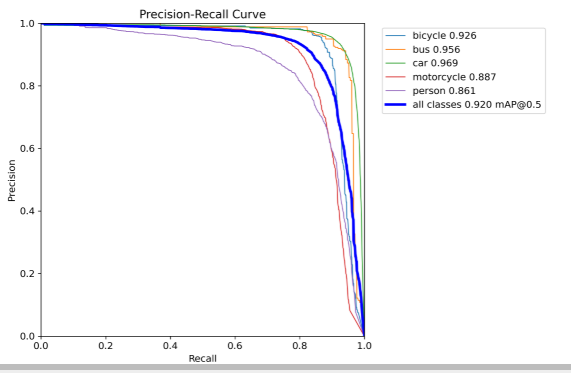

Which classes does the model do well at detecting? Remember that the more area under the curve, the better the model is performing.

### Run YOLO on Image

We can confidently start using the YOLO model to detect objects in our images.

**Task 3.7.14:** Detect the objects in image `istanbul_traffic/test/3c794894a576d0d6355379613c2dadc5.jpg`. Set the confidence to 50% and make sure to save the results.

In [ ]:
image_path_task = Path("istanbul_traffic/test/3c794894a576d0d6355379613c2dadc5.jpg")

result = saved_model.predict(image_path_task, conf=0.5, save=True, save_txt=True)

print(type(result))

The next thing we'd like to check is how many objects we detected.

**Task 3.7.15:** Determine the number of objects we detected

In [ ]:
num_detections = len(result[0].boxes.cls)
print(f"Number of objects detected: {len(result[0].boxes.cls)}")

**Task 3.7.16:** Create a dictionary that maps class names to how many objects we detected. E.g., how many "cars" we detected.

In [ ]:
detected_objects = Counter([saved_model.names[int(idx)] for idx in result[0].boxes.cls])
print(detected_objects)

#output
Counter({'motorcycle': 8, 'car': 6})


YOLO gain popularity because it's both fast and accurate.

**Task 3.7.17:** Calculate the total time object detection took.

In [ ]:
total_time = sum(result[0].speed.values())

print(f"Total time in milliseconds: {total_time}")

#output
Total time in milliseconds: 533.5056781768799


We have configured YOLO to save the image with the bounding boxes. Let's see how it did.

**Task 3.7.18:** Create a path object with the location of the saved results.

In [ ]:
location_of_results = Path(result[0].save_dir)
print(f"Location of saved results: {location_of_results}")

#output
Location of saved results: runs/detect/predict


With the location of the saved results, we can take a look of the drawn bounding boxes from running YOLO.

In [ ]:
Image.open(location_of_results / "3c794894a576d0d6355379613c2dadc5.jpg")

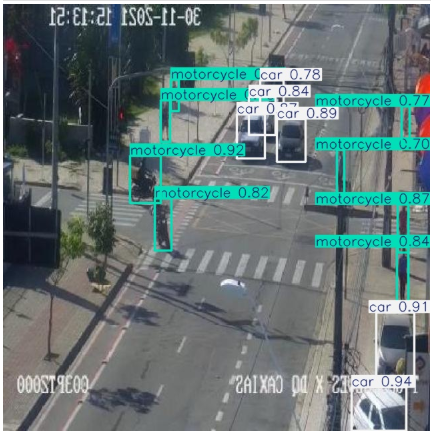

How did we fair? If you are not satisfied with the results, what would you recommend?

**Task 3.7.19:** Run YOLO on all test images, `istanbul_traffic/test`. Set the confidence to 50% and save the results.

In [ ]:
test_images_path = Path("istanbul_traffic/test")
results_test = saved_model.predict(test_images_path, conf=0.5, save=True, save_txt=True)

By running YOLO on all our test images, we can determine the distribution of detected objects.

**Task 3.7.20:** Create a dictionary that maps class names to how many objects we detected across all of the test images. E.g., how many "cars" we detected.

In [ ]:
detected_objects_test = Counter([saved_model.names[int(idx)] for result in results_test for idx in result.boxes.cls])

detected_objects_test

#output
Counter({'car': 1885,
         'motorcycle': 549,
         'person': 354,
         'bicycle': 125,
         'bus': 40}
       )